# Face Recognition by Kun Lin
## Brief Description
### Data set
ChokePoint Dataset (http://arma.sourceforge.net/chokepoint/)
-  Training: G1 (P1E_S1_C1, P1E_S2_C2, P1L_S1_C1, P1L_S2_C2)
-  Test: G2 (P1E_S3_C3, P1E_S4_C1, P1L_S3_C3, P1L_S4_C1)

### Process description
This is about brief process description. 
-  Preprocess 
-  Encoding Faces 
-  Building Classifier 
-  Evaluation

## Step 0_1: Import libraries

In [1]:
import os 
import glob
import cv2
import pickle
from skimage.io import imread
from matplotlib import pyplot as plt
import dlib
import argparse
import imutils
from imutils import face_utils
import numpy as np
from sklearn import decomposition
import pandas as pd
from imutils.face_utils import FaceAligner

## Step 0_2: Read in data

In [2]:
os.getcwd()

'/Users/Queena/Documents/CDMacademic/CSC481/FINAL_PROJECT'

In [3]:
os.getcwd()

'/Users/Queena/Documents/CDMacademic/CSC481/FINAL_PROJECT'

In [4]:
os.chdir('Dataset')

In [6]:
Training_name = ["P1E_S1_C1","P1E_S2_C2","P1L_S1_C1","P1L_S2_C2"]
Test_name = ["P1E_S3_C3","P1E_S4_C1","P1L_S3_C3","P1L_S4_C1"]

In [5]:
# Read in the data and make the labels meanwhile
def read_label3(folder_names, original_path):
    '''Read in images and realted labels in the format of two lists'''
    images = list()
    labels = list()
    folders = os.listdir(original_path)
    
    for folder in folders:
        if folder in folder_names:
            path_folder = os.path.join(original_path, folder)
            sub_folders = os.listdir(path_folder)
            for sub_folder in sub_folders[1:]:
                path_file = os.path.join(path_folder, sub_folder)
                direct_file = str(original_path)+"/"+str(folder)+"/"+str(sub_folder)+"/*.pgm"
                label = str(sub_folder)
                for image in glob.glob(direct_file):
                    labels.append(label)
                    images.append(cv2.imread(image,0))
    return images, labels

In [9]:
def image_dataset_info(image, label):
    if len(image) == len(label):
        print('There are {} images about {} individual'.format(len(image),len(set(label))))
    else:
        print('Error about the images and labels relatinoship')

In [7]:
%%time
original_path = "."
train_images, train_labels = read_label3(Training_name, original_path)

CPU times: user 466 ms, sys: 951 ms, total: 1.42 s
Wall time: 2.91 s


In [8]:
%%time
original_path = "."
test_images, test_labels = read_label3(Test_name, original_path)

CPU times: user 417 ms, sys: 855 ms, total: 1.27 s
Wall time: 2.53 s


In [10]:
image_dataset_info(train_images, train_labels)
image_dataset_info(test_images, test_labels)

There are 5418 images about 25 individual
There are 5009 images about 24 individual


## Part 1: Preprocess: Normalize the faces

-  Scale and rotate images

To have the distance between eyes is always the defined number of pixels (48 pixels in this case)

-  Cropped to 96*96 (same with the given cropped images)
-  Histogram equalization
-  Mask with an elliptical mask (or other masks?)

### Step 1: Scale and rotate images (projection to the frontal face)
Face Alignment

##### 1. Face detection and landmark detection
Use an already trained model (dlib's 68 landmarks) shape_predictor_68_face_landmarks.dat

In [17]:
def show_image(image):
    plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
    plt.show()

In [12]:
face_path = "/Users/Queena/Documents/CDMacademic/CSC481/FINAL_PROJECT/Dataset"
predictor_path= "/Users/Queena/Documents/CDMacademic/CSC481/FINAL_PROJECT/shape_predictor_68_face_landmarks.dat"  
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

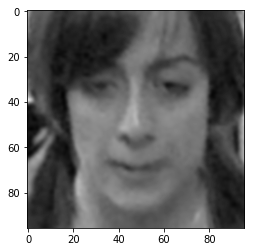

In [18]:
test_image = train_images[1]
test_case = test_image
show_image(test_case)

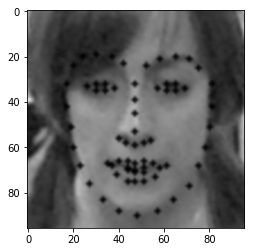

In [19]:
# show 68 face landmarks in test case
rects = detector(test_case, 0)
for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(test_case, rect)
        shape = face_utils.shape_to_np(shape)
    
        # Draw on our image, all the finded cordinate points (x,y) 
        for (x, y) in shape:
            cv2.circle(test_case, (x, y), 1, (0, 0, 255), -1)
show_image(test_case)

Disadvantage -- not all the faces can be detected, which is limited by the image resolution. Here is another failed example attached below

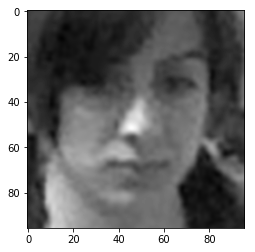

In [21]:
fail_test = train_images[30]
show_image(fail_test)

In [22]:
fail_rects = detector(fail_test, 0)
len(fail_rects)

0

##### 2. Make the face alignment based on the landmarks

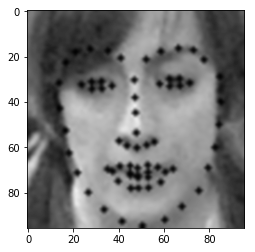

In [27]:
# face alignment based on test case
fa = FaceAligner(predictor, desiredFaceWidth=96)
image = imutils.resize(test_case, width=800)
for rect in rects:
    # extract the ROI of the *original* face, then align the face
    # using facial landmarks
    faceAligned = fa.align(test_case, image, rect)
show_image(faceAligned)

##### 3. Build function screening very low-resolution images and do the aligement and histogram equalization
This is a function created based on the previous exploartion on the test cases or some other individual cases, which will provide more scaled information in the whole dataset. 

In [41]:
def pre_images(images_list,labels_list, facewidth,
               pretrained_predictor_model_path, 
               hist_type="global", hist=True):
    '''This is preprocess process, 
    which only leave the recognizable images,
    align the images,
    control image size to 96*96,
    apply histgram equalization based on the images
    hist_type: the parameter to decide which type of histogram equalization to use
    for local histogram equalization, I used the default setting of CLAHE, which can be manipulated if needed'''
    
    new_images = list()
    new_labels = list()
    fault_images = list()
    total_len = len(images_list)
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(pretrained_predictor_model_path)
    fa = FaceAligner(predictor, desiredFaceWidth=facewidth)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    for i in range(total_len):
        image = images_list[i]
        rect = detector(image, 0)
        if len(rect)==1:
            new_labels.append(labels_list[i])
            image2 = imutils.resize(image, width=800)
            for rec in rect:
                faceAligned = fa.align(image, image2, rec)
                if hist is True:
                    if hist_type == 'global':
                        faceAligned_equ = cv2.equalizeHist(faceAligned)
                    elif hist_type == 'local':
                        faceAligned_equ = clahe.apply(faceAligned)
                    new_images.append(faceAligned_equ)
                else:
                    new_images.append(faceAligned)
        elif len(rect)==0:
            fault_images.append(image)
    return new_images, new_labels, fault_images    

In [38]:
%%time
pretrained_predictor_model_path = "/Users/Queena/Documents/CDMacademic/CSC481/FINAL_PROJECT/shape_predictor_68_face_landmarks.dat"
# no histogram equalization
train_images_pre1, train_labels_pre1, train_fault_images1 = pre_images(train_images, train_labels, 
                                                                       96, pretrained_predictor_model_path,
                                                                       hist=False)

test_images_pre1, test_labels_pre1, test_fault_images1 = pre_images(test_images, test_labels, 
                                                                    96, pretrained_predictor_model_path,
                                                                    hist=False)

CPU times: user 54.8 s, sys: 1.13 s, total: 55.9 s
Wall time: 52.7 s


In [39]:
%%time
pretrained_predictor_model_path = "/Users/Queena/Documents/CDMacademic/CSC481/FINAL_PROJECT/shape_predictor_68_face_landmarks.dat"
# global histogram equalization
train_images_pre2, train_labels_pre2, train_fault_images2 = pre_images(train_images, train_labels, 
                                                                       96, pretrained_predictor_model_path)

test_images_pre2, test_labels_pre2, test_fault_images2 = pre_images(test_images, test_labels, 
                                                                    96, pretrained_predictor_model_path)

CPU times: user 54.6 s, sys: 1.06 s, total: 55.7 s
Wall time: 52.6 s


In [42]:
%%time
# local histogram equalization CLAHE
train_images_pre3, train_labels_pre3, train_fault_images3 = pre_images(train_images, train_labels, 
                                                                       96, pretrained_predictor_model_path,
                                                                       hist_type="local")

test_images_pre3, test_labels_pre3, test_fault_images3 = pre_images(test_images, test_labels, 
                                                                    96, pretrained_predictor_model_path,
                                                                    hist_type="local")

CPU times: user 55.5 s, sys: 1.69 s, total: 57.2 s
Wall time: 52.2 s


In [43]:
# the three output should be the same 
# the only difference is how to enhance the images
image_dataset_info(train_images_pre1,train_labels_pre1)
image_dataset_info(train_images_pre2,train_labels_pre2)
image_dataset_info(train_images_pre3,train_labels_pre3)

There are 5193 images about 25 individual
There are 5193 images about 25 individual
There are 5193 images about 25 individual


In [44]:
image_dataset_info(test_images_pre1,test_labels_pre1)
image_dataset_info(test_images_pre2,test_labels_pre2)
image_dataset_info(test_images_pre3,test_labels_pre3)

There are 4875 images about 24 individual
There are 4875 images about 24 individual
There are 4875 images about 24 individual


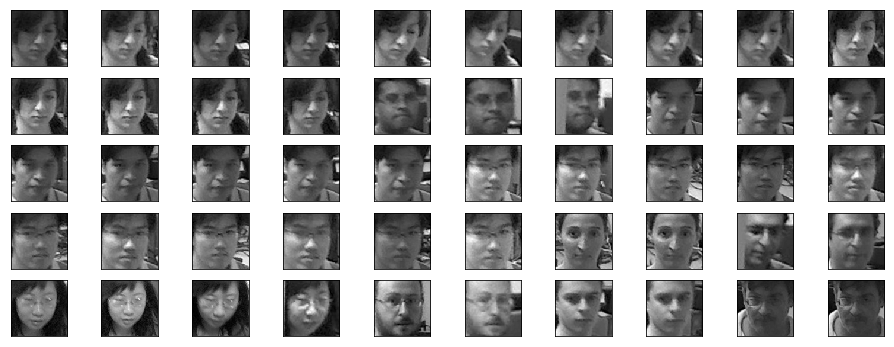

In [45]:
# What's the fault images's like?
fig = plt.figure(figsize=(16, 6))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(train_fault_images1[i],
              cmap='gray')
plt.show()

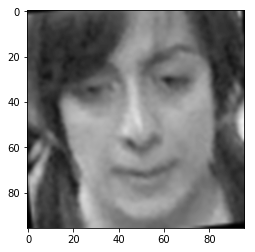

In [85]:
# no histogram
show_image(train_images_pre1[2])

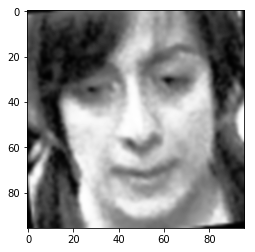

In [86]:
# global histogram
show_image(train_images_pre2[2])

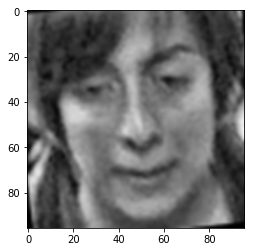

In [87]:
# local histogram
show_image(train_images_pre3[2])

## Part 2: Face Representation
In this session, the key goal is to apply different approaches to represente the faces in a new way so that it can be classified. 
-  Eigenface
-  Sparse representation

### Step 1: Eigenface Preparation: Create Matrix

In [35]:
def create_matrix(images):
    # create a all zeros matrix
    y_length = len(images)
    images_matrix = images[0].reshape(-1)
    for i in range(1, y_length):
        array_value = images[i].reshape(-1)
        images_matrix = np.vstack([images_matrix, array_value])
    return images_matrix

In [46]:
%%time
train_matrix1 = create_matrix(train_images_pre1)
train_matrix2 = create_matrix(train_images_pre2)
train_matrix3 = create_matrix(train_images_pre3)

CPU times: user 2min 19s, sys: 2min 58s, total: 5min 18s
Wall time: 5min 23s


In [47]:
%%time
test_matrix1 = create_matrix(test_images_pre1)
test_matrix2 = create_matrix(test_images_pre2)
test_matrix3 = create_matrix(test_images_pre3)

CPU times: user 2min 2s, sys: 2min 34s, total: 4min 37s
Wall time: 4min 41s


In [48]:
train_matrix1.shape

(5193, 9216)

In [49]:
test_matrix1.shape

(4875, 9216)

### Step 2: Eigenface, exploration

In [ ]:
def create_pca(matrix, components_num):
    pca = decomposition.PCA(n_components=components_num, whiten=True)
    pca_fit = pca.fit(matrix)
    pca_all_variance = pca.explained_variance_ratio_
    return pca, pca_fit, pca_all_variance

In [69]:
def present_pca_results_exploration(matrix, components_num, 
                                    threshold, table=False):
    pca = decomposition.PCA(n_components=components_num, whiten=True)
    pca_fit = pca.fit(matrix)
    pca_all_variance = pca.explained_variance_ratio_
    cum_variance = np.cumsum(pca_all_variance)
    
    ax = plt.figure(figsize=(20, 6)).add_subplot(111)
    components = [i for i in range(1,components_num+1)]
    ax.set_xticks(components)
    ax.plot(components,cum_variance,marker='*')
    plt.xlabel('Principal Component Number')
    plt.ylabel('Percentage of Variance')
    plt.show()
    
    if cum_variance[-1]>=threshold:
        print('The cumulative variance reaches {} at {} component'.
              format(threshold, np.argmax(cum_variance>=threshold)+1))
    else:
        print('The highest cumulative variance is {}'.
              format(cum_variance[-1]))

    # pca_all_variance sum table
    if table is True:
        print('Pca_all_variance Sum Table')
        sums=0
        sumlist = []
        for i in range(components_num):
            sums += pca_all_variance[i]
            sumlist.append(sums)
        pca_all_variance_sum = pd.DataFrame (sumlist,index=range(1,components_num+1)).T
        print(pca_all_variance_sum)

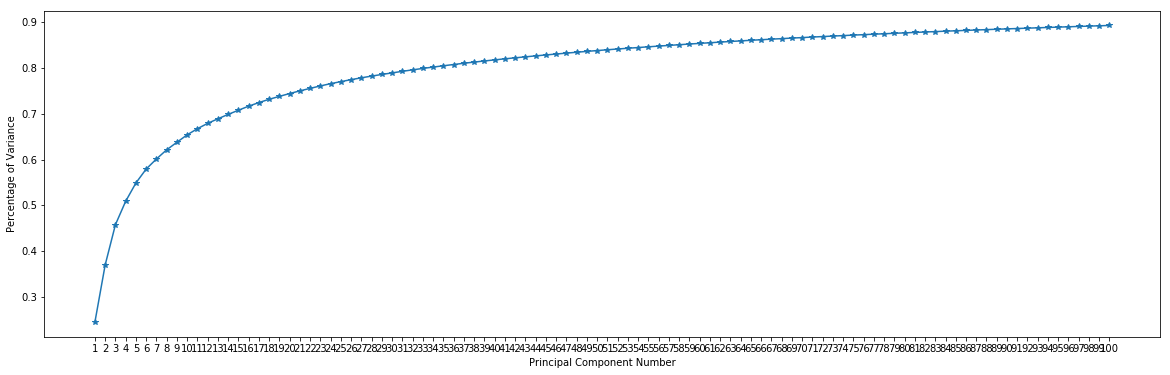

The highest cumulative variance is 0.892398649917663


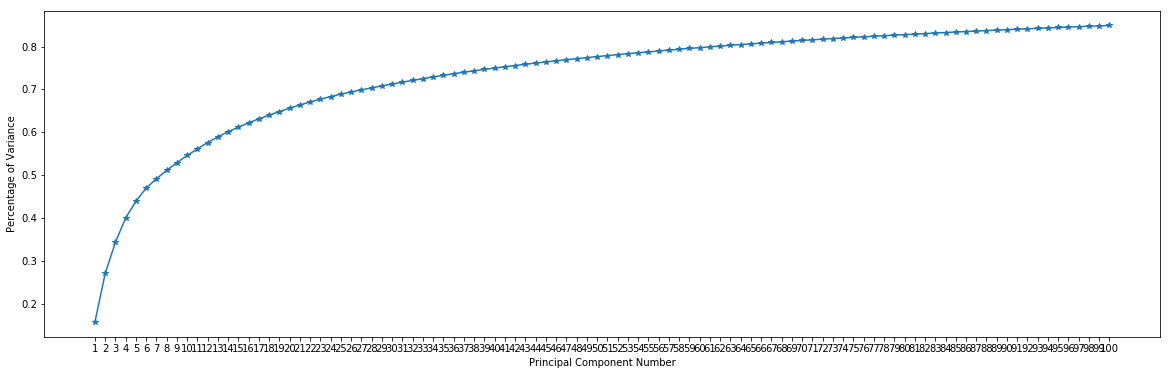

The highest cumulative variance is 0.8493770135314571


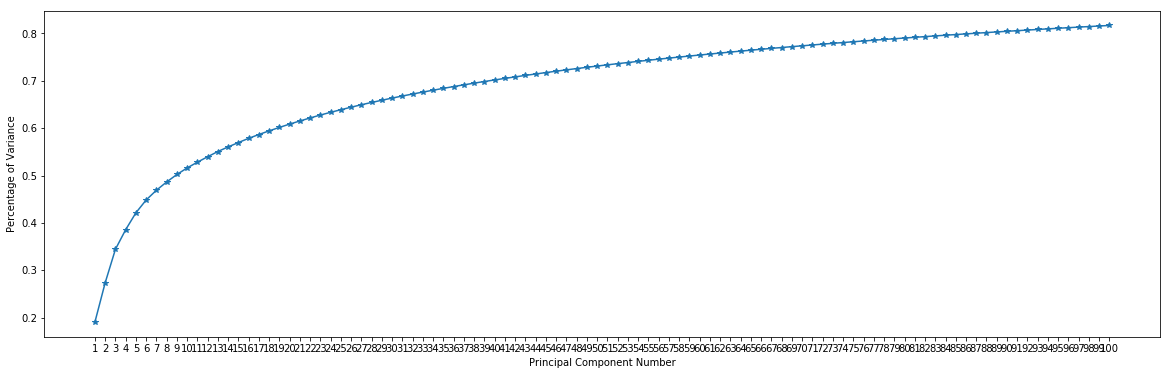

The highest cumulative variance is 0.8168711861806819
CPU times: user 48.7 s, sys: 2.87 s, total: 51.6 s
Wall time: 25.9 s


In [70]:
%%time
present_pca_results_exploration(train_matrix1, 100, 0.9)
present_pca_results_exploration(train_matrix2, 100, 0.9)
present_pca_results_exploration(train_matrix3, 100, 0.9)

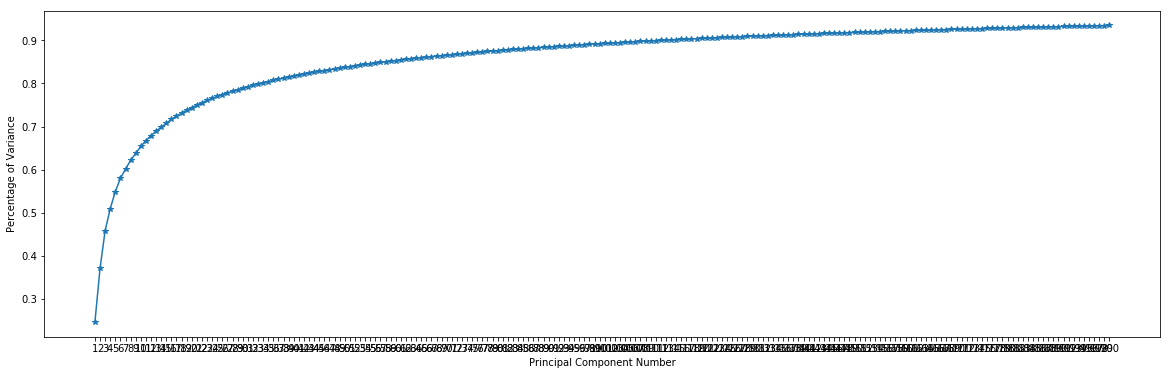

The cumulative variance reaches 0.9 at 111 component


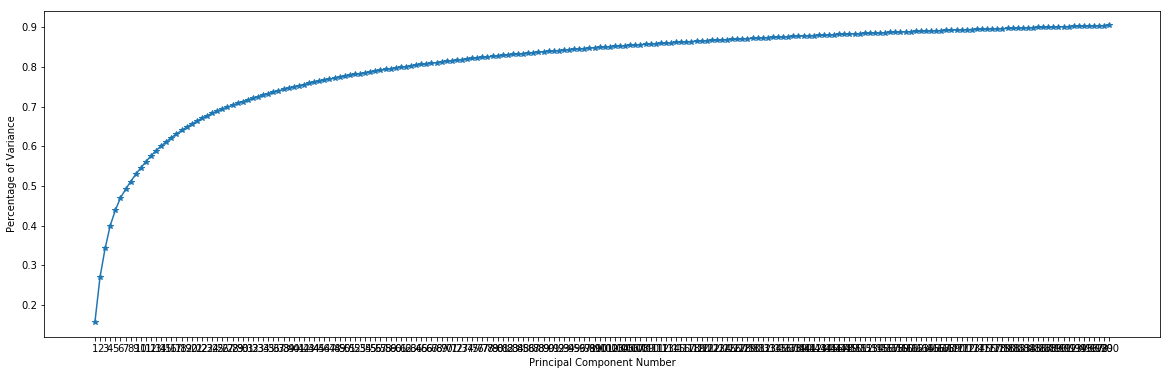

The cumulative variance reaches 0.9 at 186 component


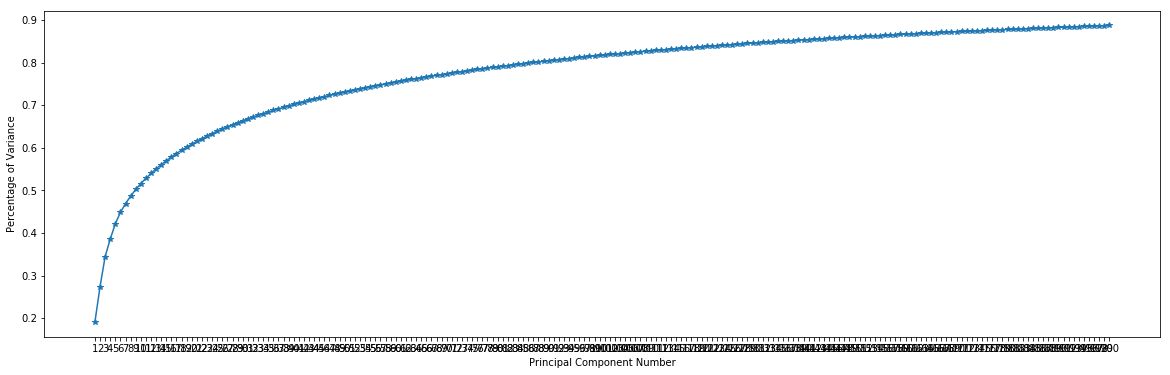

The highest cumulative variance is 0.8874418356100574
CPU times: user 1min 24s, sys: 3.4 s, total: 1min 28s
Wall time: 39 s


In [71]:
%%time
present_pca_results_exploration(train_matrix1, 200, 0.9)
present_pca_results_exploration(train_matrix2, 200, 0.9)
present_pca_results_exploration(train_matrix3, 200, 0.9)

In [78]:
def create_pca(matrix, max_comp, variance_perc):
    'create pca based on the variance requirements'
    pca = decomposition.PCA(n_components=max_comp, whiten=True)
    pca_fit = pca.fit(matrix)
    pca_all_variance = pca.explained_variance_ratio_
    cum_variance = np.cumsum(pca_all_variance)
    
    if cum_variance[-1]>=variance_perc:
        face_num = np.argmax(cum_variance>=variance_perc)+1
        print('{} eigenfaces are needed for the required variance'.
             format(face_num))
        pca_out = decomposition.PCA(n_components=face_num, whiten=True)
        pca_fit_out = pca_out.fit(matrix)
        
    else:
        print('More components, please.')
        exit()
        
    return pca_out, pca_fit_out

In [79]:
%%time
pca_train1, pca_fit_train1 = create_pca(train_matrix1, 200, 0.85)
pca_train2, pca_fit_train2 = create_pca(train_matrix2, 200, 0.85)
pca_train3, pca_fit_train3 = create_pca(train_matrix3, 200, 0.85)

58 eigenfaces are needed for the required variance
101 eigenfaces are needed for the required variance
136 eigenfaces are needed for the required variance
CPU times: user 1min 58s, sys: 5.58 s, total: 2min 3s
Wall time: 53.7 s


In [ ]:
%%time 


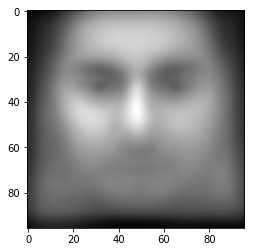

In [80]:
# pca_train1
show_image(pca_train1.mean_.reshape(train_images_pre1[0].shape))

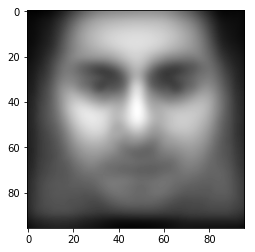

In [81]:
# pca_train2
show_image(pca_train2.mean_.reshape(train_images_pre1[0].shape))

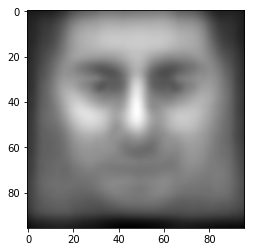

In [82]:
# pca_train3
show_image(pca_train3.mean_.reshape(train_images_pre1[0].shape))

In [88]:
def eigenface_present (pca, num, one_image):
    fig = plt.figure(figsize=(16, 6))
    for i in range(num):
        ax = fig.add_subplot(num/10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(one_image.shape),
                  cmap='gray')
    plt.show()

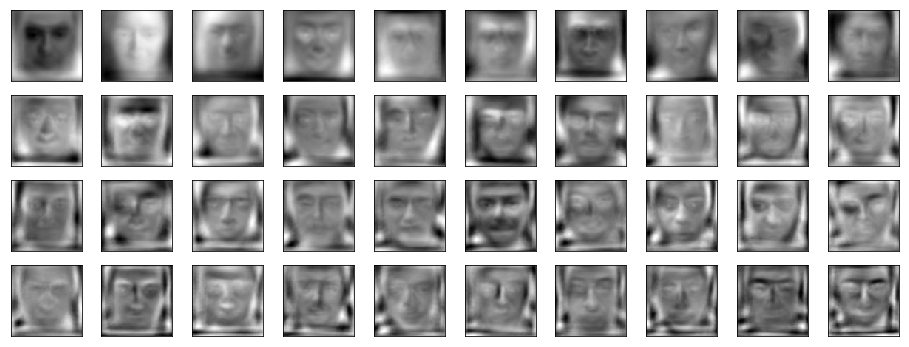

In [92]:
# no histogram equalization
eigenface_present(pca_train1, 40, train_images_pre1[0])

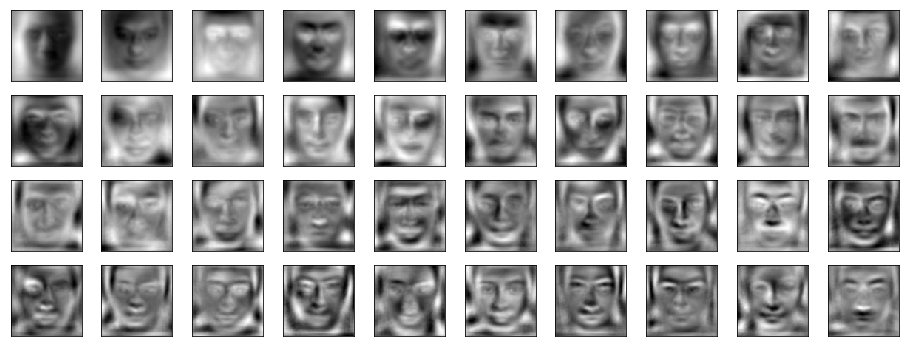

In [93]:
# global histogram equalization
eigenface_present(pca_train2, 40, train_images_pre1[0])

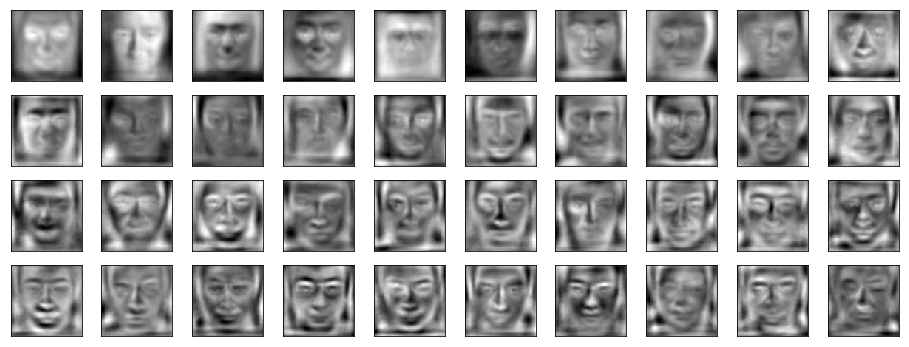

In [94]:
# local histogram equalization
eigenface_present(pca_train3, 40, train_images_pre1[0])

In [575]:
%%time
train1_pca_all = pca_train1.transform(train_matrix1)
test1_pca_all = pca_train1.transform(test_matrix1)

CPU times: user 1.85 s, sys: 350 ms, total: 2.2 s
Wall time: 1.14 s


In [132]:
%%time
train_pca_3 = pca_train1.transform(train_matrix)[:, 2:]
test_pca_3 = pca_train1.transform(test_matrix)[:, 2:]

CPU times: user 1.41 s, sys: 438 ms, total: 1.84 s
Wall time: 1.14 s


## Part 3: Face Recognition
Use the above representation approaches and build classifier -- SVM based classifier

In [98]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

### 1. No Histogram Equalization

In [110]:
def compare(labels, pred_labels):
    cm = metrics.confusion_matrix(labels, pred_labels)
    print ("Confusion matrix visulization")
    plt.matshow(cm)
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(metrics.classification_report(labels, pred_labels))

In [129]:
def results_exploration(train_matrix, test_matrix, train_labels, test_labels,
                        pca,first_comp = 0):
    train_pca = pca.transform(train_matrix)[:,first_comp:]
    test_pca = pca.transform(test_matrix)[:,first_comp:]
    clf = svm.SVC(C=5., gamma=0.001)
    clf.fit(train_pca, train_labels)
    test_labels_pred = clf.predict(test_pca)
    compare(test_labels,test_labels_pred)
    return test_labels_pred

##### Test1: no histogram equalization

Confusion matrix visulization


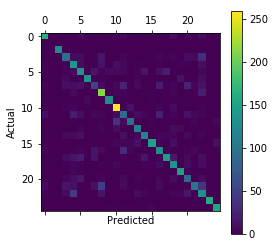

             precision    recall  f1-score   support

       0001       0.80      0.76      0.78       217
       0003       0.00      0.00      0.00         0
       0004       0.97      0.96      0.97       132
       0005       0.54      0.48      0.51       196
       0006       0.47      0.67      0.55       209
       0007       0.54      0.55      0.54       242
       0009       0.92      0.77      0.84       178
       0010       0.43      0.25      0.31       207
       0011       0.61      0.80      0.69       268
       0012       0.90      0.87      0.89       147
       0013       0.72      0.84      0.78       308
       0014       0.41      0.41      0.41       217
       0015       0.78      0.59      0.67       162
       0016       0.61      0.74      0.67       152
       0017       0.69      0.59      0.64       195
       0018       0.87      0.73      0.80       202
       0019       0.56      0.60      0.58       208
       0020       0.78      0.54      0.64   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [130]:
%%time
test1_pred_all = results_exploration(train_matrix1, test_matrix1, 
                                     train_labels_pre1, test_labels_pre1, pca_train1)

Confusion matrix visulization


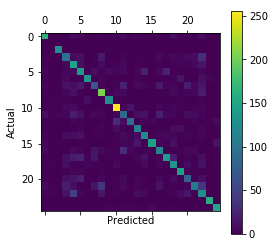

             precision    recall  f1-score   support

       0001       0.81      0.76      0.78       217
       0003       0.00      0.00      0.00         0
       0004       0.94      0.98      0.96       132
       0005       0.46      0.48      0.47       196
       0006       0.45      0.71      0.55       209
       0007       0.51      0.57      0.54       242
       0009       0.87      0.75      0.80       178
       0010       0.51      0.32      0.40       207
       0011       0.65      0.76      0.70       268
       0012       0.89      0.85      0.87       147
       0013       0.77      0.83      0.80       308
       0014       0.42      0.40      0.41       217
       0015       0.77      0.58      0.66       162
       0016       0.61      0.74      0.67       152
       0017       0.62      0.62      0.62       195
       0018       0.91      0.72      0.80       202
       0019       0.56      0.56      0.56       208
       0020       0.75      0.53      0.62   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [133]:
%%time
test1_pred_no1 = results_exploration(train_matrix1, test_matrix1, 
                                     train_labels_pre1, test_labels_pre1, pca_train1,
                                     first_comp = 1)

Confusion matrix visulization


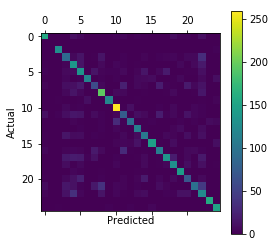

             precision    recall  f1-score   support

       0001       0.78      0.72      0.75       217
       0003       0.00      0.00      0.00         0
       0004       0.93      0.97      0.95       132
       0005       0.41      0.46      0.43       196
       0006       0.45      0.66      0.53       209
       0007       0.46      0.56      0.50       242
       0009       0.87      0.66      0.75       178
       0010       0.44      0.29      0.35       207
       0011       0.64      0.73      0.68       268
       0012       0.94      0.81      0.87       147
       0013       0.74      0.84      0.79       308
       0014       0.42      0.35      0.39       217
       0015       0.80      0.56      0.66       162
       0016       0.60      0.74      0.66       152
       0017       0.52      0.53      0.53       195
       0018       0.86      0.73      0.79       202
       0019       0.59      0.53      0.56       208
       0020       0.71      0.51      0.59   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [134]:
%%time
test1_pred_no2 = results_exploration(train_matrix1, test_matrix1, 
                                     train_labels_pre1, test_labels_pre1, pca_train1,
                                     first_comp = 2)

Confusion matrix visulization


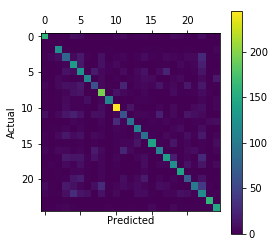

             precision    recall  f1-score   support

       0001       0.82      0.73      0.77       217
       0003       0.00      0.00      0.00         0
       0004       0.72      0.92      0.81       132
       0005       0.36      0.41      0.38       196
       0006       0.46      0.65      0.54       209
       0007       0.42      0.52      0.46       242
       0009       0.79      0.63      0.70       178
       0010       0.45      0.29      0.36       207
       0011       0.61      0.73      0.66       268
       0012       0.91      0.76      0.83       147
       0013       0.74      0.80      0.77       308
       0014       0.39      0.29      0.33       217
       0015       0.75      0.56      0.64       162
       0016       0.62      0.74      0.67       152
       0017       0.48      0.46      0.47       195
       0018       0.83      0.70      0.76       202
       0019       0.62      0.52      0.57       208
       0020       0.72      0.52      0.61   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [135]:
%%time
test1_pred_no3 = results_exploration(train_matrix1, test_matrix1, 
                                     train_labels_pre1, test_labels_pre1, pca_train1,
                                     first_comp = 3)

##### Test2: global histogram equalization

Confusion matrix visulization


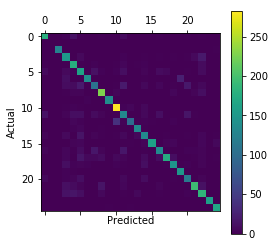

             precision    recall  f1-score   support

       0001       0.80      0.82      0.81       217
       0003       0.00      0.00      0.00         0
       0004       1.00      0.95      0.98       132
       0005       0.60      0.77      0.67       196
       0006       0.66      0.85      0.74       209
       0007       0.55      0.67      0.61       242
       0009       0.90      0.78      0.84       178
       0010       0.64      0.51      0.57       207
       0011       0.82      0.85      0.84       268
       0012       0.95      0.95      0.95       147
       0013       0.82      0.92      0.87       308
       0014       0.57      0.60      0.59       217
       0015       0.89      0.61      0.73       162
       0016       0.85      0.88      0.86       152
       0017       0.65      0.69      0.67       195
       0018       0.98      0.80      0.88       202
       0019       0.75      0.65      0.69       208
       0020       0.90      0.66      0.76   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [136]:
%%time
test2_pred_all = results_exploration(train_matrix2, test_matrix2, 
                                     train_labels_pre2, test_labels_pre2, pca_train2)

Confusion matrix visulization


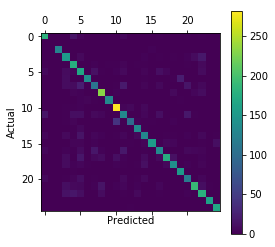

             precision    recall  f1-score   support

       0001       0.80      0.83      0.82       217
       0003       0.00      0.00      0.00         0
       0004       1.00      0.95      0.98       132
       0005       0.62      0.77      0.69       196
       0006       0.66      0.85      0.74       209
       0007       0.55      0.69      0.61       242
       0009       0.95      0.78      0.86       178
       0010       0.62      0.52      0.57       207
       0011       0.82      0.87      0.84       268
       0012       0.96      0.90      0.93       147
       0013       0.80      0.92      0.85       308
       0014       0.60      0.60      0.60       217
       0015       0.88      0.60      0.72       162
       0016       0.82      0.89      0.85       152
       0017       0.65      0.66      0.65       195
       0018       0.96      0.77      0.85       202
       0019       0.74      0.64      0.69       208
       0020       0.87      0.66      0.75   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [137]:
%%time
test2_pred_no1 = results_exploration(train_matrix2, test_matrix2, 
                                     train_labels_pre2, test_labels_pre2, pca_train2,
                                     first_comp = 1)

Confusion matrix visulization


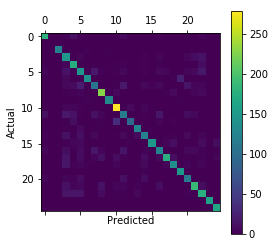

             precision    recall  f1-score   support

       0001       0.84      0.82      0.83       217
       0003       0.00      0.00      0.00         0
       0004       0.99      0.93      0.96       132
       0005       0.49      0.76      0.60       196
       0006       0.65      0.83      0.73       209
       0007       0.55      0.60      0.57       242
       0009       0.93      0.79      0.85       178
       0010       0.60      0.52      0.56       207
       0011       0.80      0.85      0.82       268
       0012       0.95      0.90      0.93       147
       0013       0.79      0.91      0.84       308
       0014       0.58      0.54      0.56       217
       0015       0.88      0.57      0.69       162
       0016       0.84      0.86      0.85       152
       0017       0.69      0.64      0.66       195
       0018       0.93      0.74      0.83       202
       0019       0.66      0.61      0.63       208
       0020       0.88      0.66      0.75   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [138]:
%%time
test2_pred_no2 = results_exploration(train_matrix2, test_matrix2, 
                                     train_labels_pre2, test_labels_pre2, pca_train2,
                                     first_comp = 2)

Confusion matrix visulization


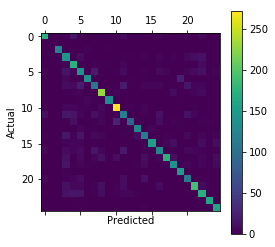

             precision    recall  f1-score   support

       0001       0.82      0.80      0.81       217
       0003       0.00      0.00      0.00         0
       0004       0.96      0.92      0.94       132
       0005       0.48      0.72      0.58       196
       0006       0.63      0.83      0.72       209
       0007       0.53      0.59      0.56       242
       0009       0.90      0.78      0.83       178
       0010       0.58      0.52      0.55       207
       0011       0.78      0.86      0.82       268
       0012       0.94      0.90      0.92       147
       0013       0.83      0.88      0.86       308
       0014       0.55      0.54      0.55       217
       0015       0.81      0.54      0.65       162
       0016       0.84      0.84      0.84       152
       0017       0.65      0.59      0.62       195
       0018       0.92      0.75      0.83       202
       0019       0.68      0.60      0.64       208
       0020       0.88      0.66      0.75   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [139]:
%%time
test2_pred_no3 = results_exploration(train_matrix2, test_matrix2, 
                                     train_labels_pre2, test_labels_pre2, pca_train2,
                                     first_comp = 3)

##### Test3: local histogram equalization

Confusion matrix visulization


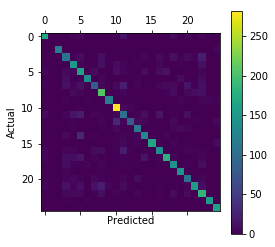

             precision    recall  f1-score   support

       0001       0.82      0.77      0.80       217
       0003       0.00      0.00      0.00         0
       0004       1.00      0.92      0.96       132
       0005       0.51      0.55      0.53       196
       0006       0.64      0.72      0.68       209
       0007       0.54      0.67      0.60       242
       0009       0.89      0.76      0.82       178
       0010       0.60      0.40      0.48       207
       0011       0.67      0.77      0.72       268
       0012       0.90      0.83      0.86       147
       0013       0.75      0.92      0.83       308
       0014       0.47      0.49      0.48       217
       0015       0.80      0.51      0.62       162
       0016       0.68      0.77      0.72       152
       0017       0.70      0.67      0.68       195
       0018       0.94      0.82      0.88       202
       0019       0.69      0.65      0.67       208
       0020       0.83      0.68      0.75   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [140]:
%%time
test3_pred_all = results_exploration(train_matrix3, test_matrix3, 
                                     train_labels_pre3, test_labels_pre3, pca_train3)

Confusion matrix visulization


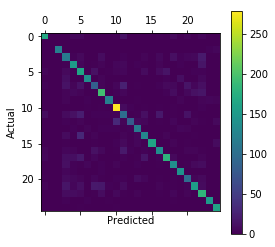

             precision    recall  f1-score   support

       0001       0.82      0.77      0.79       217
       0003       0.00      0.00      0.00         0
       0004       0.99      0.92      0.95       132
       0005       0.47      0.58      0.52       196
       0006       0.65      0.73      0.69       209
       0007       0.54      0.68      0.60       242
       0009       0.86      0.78      0.82       178
       0010       0.55      0.42      0.47       207
       0011       0.73      0.73      0.73       268
       0012       0.86      0.82      0.84       147
       0013       0.77      0.91      0.83       308
       0014       0.46      0.46      0.46       217
       0015       0.82      0.49      0.62       162
       0016       0.71      0.76      0.74       152
       0017       0.68      0.66      0.67       195
       0018       0.95      0.81      0.87       202
       0019       0.69      0.66      0.67       208
       0020       0.81      0.68      0.74   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [141]:
%%time
test1_pred_no1 = results_exploration(train_matrix3, test_matrix3, 
                                     train_labels_pre3, test_labels_pre3, pca_train3,
                                     first_comp = 1)

Confusion matrix visulization


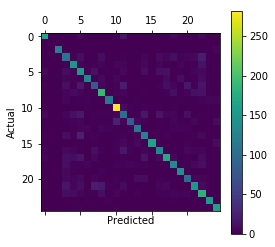

             precision    recall  f1-score   support

       0001       0.83      0.77      0.80       217
       0003       0.00      0.00      0.00         0
       0004       1.00      0.93      0.96       132
       0005       0.46      0.54      0.50       196
       0006       0.64      0.70      0.67       209
       0007       0.51      0.64      0.57       242
       0009       0.86      0.72      0.79       178
       0010       0.52      0.39      0.44       207
       0011       0.72      0.71      0.71       268
       0012       0.85      0.80      0.82       147
       0013       0.78      0.92      0.84       308
       0014       0.46      0.47      0.46       217
       0015       0.82      0.52      0.63       162
       0016       0.72      0.74      0.73       152
       0017       0.60      0.64      0.62       195
       0018       0.96      0.81      0.88       202
       0019       0.65      0.63      0.64       208
       0020       0.73      0.65      0.69   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [142]:
%%time
test1_pred_no2 = results_exploration(train_matrix3, test_matrix3, 
                                     train_labels_pre3, test_labels_pre3, pca_train3,
                                     first_comp = 2)

Confusion matrix visulization


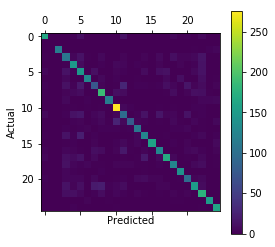

             precision    recall  f1-score   support

       0001       0.82      0.76      0.79       217
       0003       0.00      0.00      0.00         0
       0004       0.98      0.89      0.93       132
       0005       0.45      0.55      0.49       196
       0006       0.62      0.71      0.67       209
       0007       0.49      0.60      0.54       242
       0009       0.83      0.72      0.77       178
       0010       0.49      0.36      0.42       207
       0011       0.69      0.70      0.70       268
       0012       0.87      0.79      0.83       147
       0013       0.76      0.90      0.82       308
       0014       0.44      0.45      0.45       217
       0015       0.79      0.49      0.60       162
       0016       0.71      0.72      0.72       152
       0017       0.63      0.65      0.64       195
       0018       0.92      0.79      0.85       202
       0019       0.65      0.62      0.63       208
       0020       0.78      0.64      0.70   

/Users/Queena/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [143]:
%%time
test1_pred_no3 = results_exploration(train_matrix3, test_matrix3, 
                                     train_labels_pre3, test_labels_pre3, pca_train3,
                                     first_comp = 3)